## 数据预处理

In [13]:
import pandas as pd
from random import shuffle
from tqdm import tqdm
from sklearn.model_selection import train_test_split
corpus_data = pd.read_csv( "./data/corpus.tsv", sep="\t", names=["gid", "gname"])
print(f"商品标题corpus_data = {corpus_data.shape}")
train_data = pd.read_csv("./data/train.query.txt", sep="\t", names=["qid", "query"])
print(f"用户查询train_data = {train_data.shape}")
qrels = pd.read_csv("./data/qrels.train.tsv", sep="\t", names=["qid", "gid"])
print(f"查询与商品点击关系qrels = {qrels.shape}")
test_data = pd.read_csv("./data/dev.query.txt", sep="\t", names=["qid", "query"])
print(f"用户查询test_data = {test_data.shape}")

corpus_data = corpus_data.set_index("gid")
train_data = train_data.set_index("qid")
qrels = qrels.set_index("qid")
test_data = test_data.set_index("qid")
query2corpus = pd.DataFrame({"query":train_data.loc[qrels.index]['query'], "gname":corpus_data.loc[qrels.gid]['gname'].values})

商品标题corpus_data = (1001500, 2)
用户查询train_data = (100000, 2)
查询与商品点击关系qrels = (100000, 2)
用户查询test_data = (1000, 2)


In [ ]:
query2corpus.to_csv("./data/full_df.csv")

In [ ]:
X_train,X_val = train_test_split(query2corpus,test_size=0.01)

In [ ]:
X_train.to_csv("./data/X_train.csv")
X_val.to_csv("./data/X_val.csv")

In [ ]:
test_df = pd.read_csv("./data/X_train.csv")
test_df.shape

(99000, 2)

In [14]:
query2corpus.to_csv()

,query,gname
qid,,
1,美赞臣亲舒一段,领券满减】美赞臣安婴儿A+亲舒 婴儿奶粉1段850克 0-12个月宝宝
2,慱朗手动料理机,Braun/博朗 MQ3035/3000/5025料理棒手持小型婴儿辅食家用搅拌机
3,電力貓,小米WiFi电力猫无线路由器套装一对300M穿墙宝家用信号增强扩展器
4,掏夹缝工具,电梯地坎清洁工具除灰尘神器轿厢门槽缝隙掏勺维保打扫奥的斯三菱
5,飞推vip,飞逗推拍 店主邀请码 去水印 创意视频一键制作视频
...,...,...
99996,新娘手饰品,独家原创高端多色婚礼手腕花伴娘姐妹手花 新娘结婚腕花 绑带配盒
99997,一吨铲车,小型铲车装载机四驱养殖场小铲车工程农用推土机电动单缸小装载机
99998,避風塘蟹香蒜酥,十味观避风塘蟹香蒜酥/潮汕沙茶酱/XO酱美食推荐数量有限台湾直邮


In [5]:
test_data

,query
qid,
200001,甲黄酸阿怕替尼片
200002,索泰zbox
200003,kfc游戏机
200004,bunny成兔粮
200005,铁线威灵仙
...,...
200996,液压煎孑
200997,友鱼水水族
200998,玻璃水帘


In [6]:
train_data

,query
qid,
1,美赞臣亲舒一段
2,慱朗手动料理机
3,電力貓
4,掏夹缝工具
5,飞推vip
...,...
99996,新娘手饰品
99997,一吨铲车
99998,避風塘蟹香蒜酥


## 数据分析

In [55]:
# 将所有文本分词，然后存储起来
import math
import jieba
from collections import Counter
from tqdm import tqdm
sentences = []
word_set = set()
temp = corpus_data.head(10000).copy()
for row in tqdm(temp.gname.values.tolist()):
    seg_list = list(jieba.cut(row, cut_all=False))
    # sentence = " ".join([seg for seg in seg_list if seg != '' and seg != "\n" and seg != "\n\n"])
    sentences.append(seg_list)
    word_set.update(set(seg_list))

100%|██████████| 10000/10000 [00:01<00:00, 5811.31it/s]


In [63]:
# tf idf
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer,TfidfTransformer
vectorizer = CountVectorizer()    
transformer = TfidfTransformer()
concat_sentences = [" ".join(sent) for sent in sentences]
tfidf = transformer.fit_transform(vectorizer.fit_transform(concat_sentences))
word_array = np.array(vectorizer.get_feature_names()) #所有文本的关键字
weight = tfidf.toarray()              #对应的tfidf矩阵
# 取每一个的重要性前10的单词，伪造一个query
import numpy as np
n = 4
top_word_idx = np.argpartition(weight, -n, axis=1)[:,-n:]
tf_idf_query = []
for i in range(len(top_word_idx)):
    tf_idf_query.append(word_array[top_word_idx[i]].tolist())
# print(fake_query)
temp[f"fake_query_TF-IDF-{n}"] = ["".join(ws) for ws in fake_query]
# def f(x):
#     L = len(x.gname)
#     cut_at = min(L//2,10)
#     return x.gname[:cut_at]
# temp['fake_query_former10'] = temp.apply(f,axis=1)
temp[f'fake_query_former4word'] = ["".join(sent[:4]) for sent in sentences]
temp['fake_query_former2word+TF-IDF-2'] = ["".join(list(dict.fromkeys(sent[:4]+tfidf[:2]))) for sent,tfidf in zip(sentences,tf_idf_query)]
with pd.option_context('display.max_rows', 100):
    display(temp)


/Users/bytedance/opt/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,gname,fake_query_TF-IDF-4,fake_query_former4word,fake_query_former2word+TF-IDF-2
gid,,,,
1,铂盛弹盖文艺保温杯学生男女情侣车载时尚英文锁扣不锈钢真空水杯,真空英文盛弹锁扣,铂盛弹盖文艺,铂盛弹盖文艺真空英文
2,可爱虎子华为荣耀X30i手机壳荣耀x30防摔全包镜头honorx30max液态硅胶虎年情侣女...,呆萌虎子荣耀honorx30max,可爱虎子华为荣耀,可爱虎子华为荣耀呆萌
3,190色素色亚麻棉平纹布料 衬衫裙服装定制手工绣花面料 汇典亚麻,色素平纹布汇典亚麻棉,190色素色亚麻棉,190色素色亚麻棉平纹布
4,松尼合金木工开孔器实木门开锁孔木板圆形打空神器定位打孔钻头,开孔器锁孔实木门松尼,松尼合金木工开孔器,松尼合金木工开孔器锁孔
5,微钩绿蝴蝶材料包非成品 赠送视频组装教程 需自备钩针染料,微钩自备染料包非,微钩绿蝴蝶材料,微钩绿蝴蝶材料自备
...,...,...,...,...
9996,果篮塑料卡通沥水菜篮子双层镂空果盘水果盆大小号创意厨房洗菜篮,果盘菜篮子菜篮果篮,果篮塑料卡通沥水,果篮塑料卡通沥水果盘菜篮子
9997,EVE量子元 EVE Echoes 星战前夜国际区服手游 代充 储值 氪金,区服前夜echoeseve,EVE量子元,EVE量子元 区服前夜
9998,适用21款日产14代轩逸经典汽车装饰用品门槛条迎宾踏板防踩护改装,日产门槛汽车装饰代轩,适用21款日产,适用21款日产门槛


In [129]:
# 分析idf
import math
def idf(word, count_list):
    n_contain = sum([1 for count in count_list if word in count])
    return math.log(len(count_list) / (1 + n_contain))

count_list = list()
for i in range(len(sentences)):
    count = Counter(sentences[i])
    count_list.append(count)
w2idf = {}
for w in word_set:
    w2idf[w] = idf(w,count_list)
sorted_keys = sorted(w2idf.keys(),key=lambda x:w2idf[x])
df = pd.DataFrame(w2idf.items(),columns=["word","IDF"]).sort_values(by="IDF")
# with pd.option_context('display.max_rows', None):
#     display(df)

100%|██████████| 10000/10000 [00:02<00:00, 3392.35it/s]


## 拼接fake query

In [5]:
query2corpus

,gname
query,
美赞臣亲舒一段,领券满减】美赞臣安婴儿A+亲舒 婴儿奶粉1段850克 0-12个月宝宝
慱朗手动料理机,Braun/博朗 MQ3035/3000/5025料理棒手持小型婴儿辅食家用搅拌机
電力貓,小米WiFi电力猫无线路由器套装一对300M穿墙宝家用信号增强扩展器
掏夹缝工具,电梯地坎清洁工具除灰尘神器轿厢门槽缝隙掏勺维保打扫奥的斯三菱
飞推vip,飞逗推拍 店主邀请码 去水印 创意视频一键制作视频
...,...
新娘手饰品,独家原创高端多色婚礼手腕花伴娘姐妹手花 新娘结婚腕花 绑带配盒
一吨铲车,小型铲车装载机四驱养殖场小铲车工程农用推土机电动单缸小装载机
避風塘蟹香蒜酥,十味观避风塘蟹香蒜酥/潮汕沙茶酱/XO酱美食推荐数量有限台湾直邮


In [7]:
# 将所有文本分词，然后存储起来
import math
import jieba
from collections import Counter
from tqdm import tqdm
sentences = []
temp = query2corpus.copy()
for row in tqdm(temp.gname.values.tolist()):
    seg_list = list(jieba.cut(row, cut_all=False))
    # sentence = " ".join([seg for seg in seg_list if seg != '' and seg != "\n" and seg != "\n\n"])
    sentences.append(seg_list)
# with pd.option_context('display.max_rows', 100):
#     display(temp)


  0%|          | 0/100000 [00:00<?, ?it/s]Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/yp/fg1gg5v164gct6fcht35czvh0000gp/T/jieba.cache
Loading model cost 0.701 seconds.
Prefix dict has been built successfully.
100%|██████████| 100000/100000 [00:21<00:00, 4630.73it/s]


In [8]:
temp.head(100)

,gname
query,
美赞臣亲舒一段,领券满减】美赞臣安婴儿A+亲舒 婴儿奶粉1段850克 0-12个月宝宝
慱朗手动料理机,Braun/博朗 MQ3035/3000/5025料理棒手持小型婴儿辅食家用搅拌机
電力貓,小米WiFi电力猫无线路由器套装一对300M穿墙宝家用信号增强扩展器
掏夹缝工具,电梯地坎清洁工具除灰尘神器轿厢门槽缝隙掏勺维保打扫奥的斯三菱
飞推vip,飞逗推拍 店主邀请码 去水印 创意视频一键制作视频
...,...
奥利奥玫瑰葡萄,亿滋奥利奥原味巧克力薄脆巧轻脆夹心小饼干冰淇淋官方旗舰店官网
菜刀菜板剪刀,砧板剪刀切菜剪子剪刀剪菜神器多功能切菜神器多用剪刀剪菜剪子
梅菜干,盛盛耳梅干菜100g梅干菜扣肉特产干货霉菜无沙


In [9]:
temp['fake_query'] = ["".join(seg[:5]) for seg in sentences]

In [10]:
temp

,gname,fake_query
query,,
美赞臣亲舒一段,领券满减】美赞臣安婴儿A+亲舒 婴儿奶粉1段850克 0-12个月宝宝,领券满减】美赞臣安
慱朗手动料理机,Braun/博朗 MQ3035/3000/5025料理棒手持小型婴儿辅食家用搅拌机,Braun/博朗 MQ3035
電力貓,小米WiFi电力猫无线路由器套装一对300M穿墙宝家用信号增强扩展器,小米WiFi电力猫无线
掏夹缝工具,电梯地坎清洁工具除灰尘神器轿厢门槽缝隙掏勺维保打扫奥的斯三菱,电梯地坎清洁工具除
飞推vip,飞逗推拍 店主邀请码 去水印 创意视频一键制作视频,飞逗推拍 店主邀请
...,...,...
新娘手饰品,独家原创高端多色婚礼手腕花伴娘姐妹手花 新娘结婚腕花 绑带配盒,独家原创高端多色婚礼
一吨铲车,小型铲车装载机四驱养殖场小铲车工程农用推土机电动单缸小装载机,小型铲车装载机四驱养殖场
避風塘蟹香蒜酥,十味观避风塘蟹香蒜酥/潮汕沙茶酱/XO酱美食推荐数量有限台湾直邮,十味观避风塘蟹香蒜酥


In [75]:
temp.to_csv("./data/fake_train.csv",index=False)

In [78]:
pd.read_csv("./data/fake_train.csv")

,query,gname
0,铂盛弹盖文艺,铂盛弹盖文艺保温杯学生男女情侣车载时尚英文锁扣不锈钢真空水杯
1,可爱虎子华为荣耀,可爱虎子华为荣耀X30i手机壳荣耀x30防摔全包镜头honorx30max液态硅胶虎年情侣女...
2,190色素色亚麻棉,190色素色亚麻棉平纹布料 衬衫裙服装定制手工绣花面料 汇典亚麻
3,松尼合金木工开孔器,松尼合金木工开孔器实木门开锁孔木板圆形打空神器定位打孔钻头
4,微钩绿蝴蝶材料,微钩绿蝴蝶材料包非成品 赠送视频组装教程 需自备钩针染料
...,...,...
1001495,专治牛皮癣特效中,专治牛皮癣特效中药膏专用药浴软膏银屑病老偏方泡澡沐浴露洗发水
1001496,梳妆台镜子遮挡帘,梳妆台镜子遮挡帘神器卫生间免打孔魔术贴拉帘轨道式防尘布帘滑轨
1001497,护目镜透明化工实验室,护目镜透明化工实验室防护眼镜农药防风烟雾打磨粉尘飞溅平光镜
1001498,克莱因蓝发带女,克莱因蓝发带女日常外戴秋冬百搭宽边运动头箍韩国网红头饰酷街头


<AxesSubplot:ylabel='Count'>

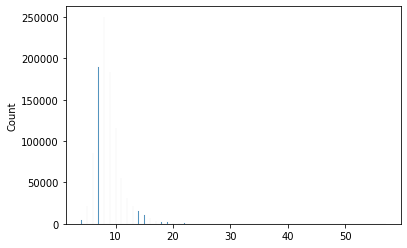

In [67]:
import seaborn as sns
sns.histplot([len(i) for i in temp['fake_query_former4word'].values])

In [18]:
corpus_data.to_csv("./data/corpus.csv",index=False)

In [14]:
pd.concat(
    [
        corpus_data.rename(columns={'gname':'sentence'}),
        # train_data.rename(columns={'query':'sentence'}),
        # test_data.rename(columns={'query':'sentence'})
    ],
    ignore_index=True).to_csv("./data/full_corpus_querys.csv",index=False)

In [15]:
pd.read_csv("./data/full_corpus_querys.csv")

,sentence
0,铂盛弹盖文艺保温杯学生男女情侣车载时尚英文锁扣不锈钢真空水杯
1,可爱虎子华为荣耀X30i手机壳荣耀x30防摔全包镜头honorx30max液态硅胶虎年情侣女...
2,190色素色亚麻棉平纹布料 衬衫裙服装定制手工绣花面料 汇典亚麻
3,松尼合金木工开孔器实木门开锁孔木板圆形打空神器定位打孔钻头
4,微钩绿蝴蝶材料包非成品 赠送视频组装教程 需自备钩针染料
...,...
1102495,液压煎孑
1102496,友鱼水水族
1102497,玻璃水帘
1102498,至关车载充电器qk789


<AxesSubplot:ylabel='Count'>

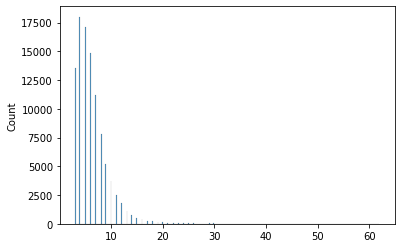

In [49]:
import seaborn as sns
sns.histplot([len(i[0]) for i in train_data.values])

## 简繁转化

In [11]:
from pyhanlp import *
import pandas as pd
from tqdm import tqdm
full_df = pd.read_csv("./data/full_query_corpus_pairs.csv")
fake_query2corpus = {}
for i in tqdm(range(len(full_df.head(100)))):
    row = full_df.iloc[i]
    q = row['query']
    q = HanLP.convertToSimplifiedChinese(q)
    c = row['gname']
    c = q = HanLP.convertToSimplifiedChinese(c)
    fake_query2corpus[q]=c
    # fake_querys = gen_synonyms(q,k=3)
    # for fq in fake_querys:
    #     fake_query2corpus[fq] = c
fake_query2corpus_df = pd.DataFrame(fake_query2corpus.items(),columns=["query","gname"])
fake_query2corpus_df
# full_df.to_csv("./data/auged_query2corpus.csv",index=False)

下载 https://file.hankcs.com/hanlp/hanlp-1.8.3-release.zip 到 /Users/bytedance/opt/miniconda3/envs/py38/lib/python3.8/site-packages/pyhanlp/static/hanlp-1.8.3-release.zip
100%   1.8 MiB  51.0 KiB/s ETA:  0 s [=========================================]
下载 https://file.hankcs.com/hanlp/data-for-1.7.5.zip 到 /Users/bytedance/opt/miniconda3/envs/py38/lib/python3.8/site-packages/pyhanlp/static/data-for-1.8.3.zip
 22% 637.7 MiB  69.0 KiB/s ETA:  2 h  2 m 34 s [======                         ]

下载失败 https://file.hankcs.com/hanlp/data-for-1.7.5.zip 由于 KeyboardInterrupt()
请参考 https://od.hankcs.com/book/intro_nlp/ 执行手动安装.
或手动下载 https://file.hankcs.com/hanlp/data-for-1.7.5.zip 到 /Users/bytedance/opt/miniconda3/envs/py38/lib/python3.8/site-packages/pyhanlp/static/data-for-1.8.3.zip


NameError: name 'exit' is not defined